# Style 섞기

- 두 개 이미지의 스타일 -> 하나의 콘텐츠 이미지에 적용

### 1. 이미지 로드 및 전처리 함수 정의

In [2]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import torch

In [14]:
# 함수 정의: 이미지 로드 + Transform
def load_image(img_url, max_size=400, shape=None):
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    if shape:
        image = image.resize(shape, Image.LANCZOS)
    else:
        image.thumbnail((max_size, max_size))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

In [15]:
# 함수 정의: Tensor -> 이미지 변환
def image_convert(tensor):
    image = tensor.to("cpu").clone().detach().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225]
    image = image + [0.485, 0.456, 0.406]
    return image.clip(0, 1)

### 2. 특징 추출 함수 정의

In [16]:
# 함수 정의: 특정 렝이어를 통과한 feature 반환 == 특정 추출
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features


In [17]:
# 함수 정의: 스타일 표현을 위한 행렬(채널간 관계) 계산 함수
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

### 3. Style Mixing 함수 정의

In [27]:
def style_transfer_mix(content, style1, style2, model, mix_ratio=0.5, steps=200, content_weight=1, style_weight=1e6):

  with torch.no_grad():
    content_features = get_features(content, model)
    style1_features = get_features(style1, model)
    style2_features = get_features(style2, model)

    style_grams_mix = {}
    for i in style1_features:
      gram1 = gram_matrix(style1_features[i])
      gram2 = gram_matrix(style2_features[i])
      style_grams_mix[i] = mix_ratio * gram1 + (1 - mix_ratio) * gram2

  target = content.clone().requires_grad_(True)
  optim = torch.optim.Adam([target], lr=0.003)

  for i in range(steps):
    target_features = get_features(target, model)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for j in style_grams_mix:
      target_gram = gram_matrix(target_features[j])
      style_gram = style_grams_mix[j]
      layer_loss = torch.mean((target_gram - style_gram) ** 2)
      style_loss += layer_loss / (target_features[j].shape[1] ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss
    optim.zero_grad()
    total_loss.backward()
    optim.step()

  return target

In [19]:
# ### 작업 진행 순서

# from pandas.io import feather_format


# 1. 이미지 url 설정
# 2. 모델 로드
# 3. 이미지 로드 및 전처리
# 4. style_transfer_mix 함수 호출
# 5. 결과 시각화

In [28]:
# 이미지 url
content_url = "https://www.fitpetmall.com/wp-content/uploads/2023/10/GettyImages-492548888-1.png"
style1_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"
style2_url = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"

In [29]:
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드
vgg = models.vgg19(pretrained=True).features.to(device).eval()

c:\Users\Playdata\anaconda3\envs\llm_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Playdata\anaconda3\envs\llm_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# 이미지 로드
content = load_image(content_url).to(device)
style1 = load_image(style1_url, shape=content.shape[-2:]).to(device)
style2 = load_image(style2_url, shape=content.shape[-2:]).to(device)

In [31]:
# style_transfer_mix 함수 호출에서 RuntimeError가 발생하는 원인은 주로 'target' 텐서에 requires_grad=True 옵션이 빠진 경우입니다.
# style_transfer_mix 함수 내부에서 target = content.clone() 만 있을 경우 target.requires_grad = True 처리가 없으면 optimizer가 gradient를 계산하지 못해 발생할 수 있습니다.
# 또한, torch.optim.LBFGS 등에 target만 전달하는데 requires_grad=True가 없으면 optimizer.step 시 에러가 발생합니다.
# style_transfer_mix 함수 내부에서 아래와 같이 target.requires_grad = True 구문이 있는지 확인해보세요:
#   target = content.clone().requires_grad_(True)
# 만약 없다면, style_transfer_mix 함수 내에서 아래와 같이 수정해야 합니다.
#   target = content.clone().requires_grad_(True)
#   optimizer = torch.optim.LBFGS([target])
# 혹시 함수 내부가 맞게 되어 있는데도 문제가 있으면 target, content, style1, style2 가 모두 .to(device) 되어 있는지 확인하세요.

result = style_transfer_mix(content, style1, style2, vgg)

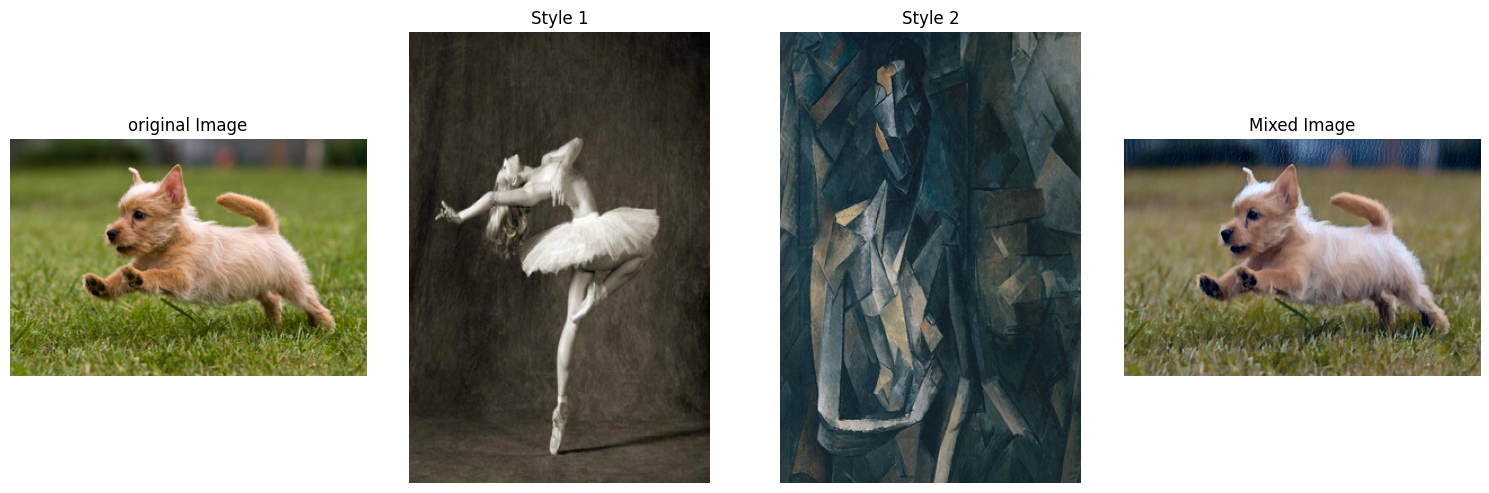

In [32]:
import matplotlib.pyplot as plt

# 결과 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(image_convert(content))
plt.title('original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_convert(style1))
plt.title('Style 1')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(image_convert(style2))
plt.title('Style 2')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_convert(result))
plt.title('Mixed Image')
plt.axis('off')

plt.tight_layout()
plt.show()